In [1]:
pip freeze


The following command must be run outside of the IPython shell:

    $ pip freeze

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from workalendar.europe import Russia
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import gc
from itertools import product
from datetime import date
import time

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


import lightgbm as lgb
from xgboost import XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor

from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import optimizers
from keras.models import load_model

# Functions

In [20]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

def mean_enc(all_data, group_cols, target_col, name, fill_c):
    gb = all_data[group_cols + [target_col]].groupby(group_cols,as_index=False).agg({target_col:{name + '_mean':'mean'}})
    #gb.reset_index(inplace=True)
    gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=group_cols).fillna(fill_c)
    return all_data
  
def mean_KFenc(data, enc_col, target_col, fill_c, n_splits):
    data= data.copy()
    y= data[target_col]; X= data[enc_col]
    new_col= enc_col + '_mean_skf'
    data[new_col]= fill_c
    skf = StratifiedKFold(n_splits=n_splits, shuffle= False, random_state=0)
    for train_index, test_index in skf.split(X, y):
        enc= data.loc[train_index].groupby(enc_col)[target_col].mean()
        #enc.reset_index(inplace=True)
        data[new_col].loc[test_index]= data[enc_col].loc[test_index].map(enc)    
    data[new_col].fillna(fill_c, inplace=True)
    return data

def feature_lags(all_data, time_col, inx_cols, name, lags, fill_c):  
    for lag in lags:
        d= all_data[inx_cols + [name]].copy().drop_duplicates(subset=inx_cols)
        d[time_col] += lag
        d= d.rename(columns= {name: name + '_previous_' + str(lag)})
        all_data = pd.merge(all_data, d, how='left', on=inx_cols).fillna(fill_c)
    del d
    return all_data

def first_last(all_data, p_cols, reference, name, fl):
    gb= all_data[p_cols + [reference]].groupby(p_cols, as_index=False)
    #gb.reset_index(inplace=True)
    if fl== 'first': 
        a=gb.first()
    if fl== 'last':
        a=gb.last()
    a= a.rename(columns={reference:fl + '_' + name})
    all_data = pd.merge(all_data, a, how='left', on=p_cols)
    if fl== 'first': 
        all_data['delta_' + fl + '_' + name]= (all_data[reference] - all_data[fl + '_' + name]).fillna(0)
    if fl== 'last': 
        all_data['delta_' + fl + '_' + name]= (all_data[reference] - all_data[fl + '_' + name]).fillna(33)
    return all_data

fill_c= 0

# Load data

In [21]:
#read_data
path= 'Data/'
t          = pd.read_csv(path + 'sales_train.csv.gz')
test            = pd.read_csv(path + 'test.csv')
items           = pd.read_csv(path + 'items.csv')
item_cats = pd.read_csv(path + 'item_categories.csv')
shops           = pd.read_csv(path + 'shops.csv')

t['date']= pd.to_datetime(t['date'], format= '%d.%m.%Y')
t= t.sort_values('date')

# EDA

## Sales
* Checking whether there ares new items in test data.

In [5]:
# Checking whether there ares new items in test data.
col= 'item_id'
new_items=len(list(set(test[col]) - set(test[col]).intersection(set(t[col]))))
new_items

363

In [6]:
#plt.scatter(t['item_id'], t['item_price'], s=0.5); plt.show()

In [7]:
#plt.scatter(t['item_id'], t['item_cnt_day'], s=0.5); plt.show()

## Shops
* There seems to be a duplications of shops 0 with 57, 1 with 58 & 10 with 11.
* Need to analyse location from google, e.g. mall, street, level, city center...  

In [8]:
# Checking wether there are new shops in test data.
col= 'shop_id'
new_shops=list(set(test[col]) - set(test[col]).intersection(set(shops[col])))
new_shops

[]

In [9]:
gb = shops.groupby('shop_name')
 
gb.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


## items

In [10]:
#gb = items.groupby('item_name')
#gb.head()

## item_category

In [11]:
#item_cats.head(10)

# Clean

In [22]:
# Cleaning and ordering based on EDA

# removing outliers
t = t[t['item_price']<50000]
t = t[t['item_cnt_day']<500]

# 

t.loc[t['shop_id'] == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

t.loc[t['shop_id'] == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

t.loc[t['shop_id'] == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

items.drop(['item_name'], axis=1, inplace=True)



item_cats['split'] = item_cats['item_category_name'].str.split('-')
item_cats['type'] = item_cats['split'].map(lambda x: x[0].strip())
item_cats['type_code'] = LabelEncoder().fit_transform(item_cats['type'])
# if subtype is nan then type
item_cats['subtype'] = item_cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_cats['subtype_code'] = LabelEncoder().fit_transform(item_cats['subtype'])
item_cats = item_cats[['item_category_id','type_code', 'subtype_code']]

In [23]:
tr_shops= list(t['shop_id'].unique())
ts_shops= list(test['shop_id'].unique())
tr_items= list(t['item_id'].unique())
ts_items= list(test['item_id'].unique())

# Check leakedges

In [13]:
#test.columns

In [14]:
#plt.scatter(t.index, t['item_cnt_day'], s=0.5); plt.show()

In [15]:
#plt.scatter(t['shop_id'], t['item_cnt_day'], s=0.5); plt.show()

In [16]:
#plt.scatter(test['shop_id'], test['ID'], s=0.5);plt.show()

In [17]:
#plt.figure(figsize=(15,15))
#plt.scatter(test['shop_id'], test['item_id'], s=0.5);plt.show()

In [18]:
#plt.figure(figsize=(15,15))
#plt.scatter(test['item_id'], test['ID'], s=0.5);plt.show()

#### There are some patterns that require further investigation in the future. 

# Create basic dataset for processing
* For each item in each shop I create an instance for each month. This way there will be a continious data of each specific item for creating features and training the model.  
* Test data will be concatenated to train data for easier processing.

### Create grid

In [24]:
# Create grid
index_cols = ['shop_id', 'item_id', 'date_block_num']

grid = [] 
for block_num in t['date_block_num'].unique():
    cur_shops = t.loc[t['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = t.loc[t['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)


grid['ID']= -1

grid= grid[grid['shop_id'].isin(ts_shops)]
grid= grid[grid['item_id'].isin(ts_items)]


g= grid.shape
print('grid', g)


# Preparing test set
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

keep= len(grid)+len(test)
print('keep: ', keep)

grid (2781025, 4)
keep:  2995225


In [25]:
# Concatenating grid & test data
all_data= pd.concat([grid, test], axis=0, ignore_index=True)#, sort=False)
all_data.fillna(0, inplace=True)
del grid

# Merging Shops, Categories, items 
all_data = pd.merge(all_data, shops, on=['shop_id'], how='left')
all_data = pd.merge(all_data, items, on=['item_id'], how='left')
all_data = pd.merge(all_data, item_cats, on=['item_category_id'], how='left')
all_data['item_category_id'] = all_data['item_category_id'].astype(np.int8)
all_data['city_code'] = all_data['city_code'].astype(np.int8)
all_data['type_code'] = all_data['type_code'].astype(np.int8)
all_data['subtype_code'] = all_data['subtype_code'].astype(np.int8)

print(all_data.shape)

(2995225, 8)


### Calculate target data
#### I will clip target to 0-20 for better convergance of the model.

In [26]:
# Target of current month
group_cols= ['shop_id', 'item_id', 'date_block_num']
gb = t.groupby(group_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=group_cols).fillna(0)

# Clipping
all_data['target']= all_data['target'].clip(0, 20, axis=0).astype(np.int8)
print(all_data.shape)

(2995225, 9)


# Features
 * Months & year.
 * Months since firs & last sales.
 * Mean price for each month, price lags & trends.
 * Working days and holydays in each month.
 * Mean encoding using skf strategy.
 * Target lags, trends & estimations.

In [27]:
# Calculate month & year
all_data['month']= (all_data['date_block_num'] % 12 + 1).astype(np.int32)
all_data['year']= (all_data['date_block_num'] // 12 + 2013).astype(np.int32)

# months since first & last sale
reference= 'date_block_num'

p_cols=['shop_id', 'item_id']; name= 'shop_item'; fl= 'first'
all_data= first_last(all_data, p_cols, reference, name, fl)

p_cols=['shop_id', 'item_id']; name= 'shop_item'; fl= 'last'
all_data= first_last(all_data, p_cols, reference, name, fl)

p_cols=['shop_id']; name= 'shop'; fl= 'first'
all_data= first_last(all_data, p_cols, reference, name, fl)

p_cols=['shop_id']; name= 'shop'; fl= 'last'
all_data= first_last(all_data, p_cols, reference, name, fl)

p_cols=['item_id']; name= 'item'; fl= 'first'
all_data= first_last(all_data, p_cols, reference, name, fl)

p_cols=['item_id']; name= 'item'; fl= 'last'
all_data= first_last(all_data, p_cols, reference, name, fl) 

In [28]:
# Prices
all_data['log_price']= np.log1p(all_data['item_price'].values)

for f in ['item_id', 'item_category_id', 'type_code', 'subtype_code']:
    all_data[f + '_mean_price']= all_data.groupby(f, as_index=False)['item_price'].mean()
    all_data[f + '_std_price']= all_data.groupby(f, as_index=False)['item_price'].std()
    all_data[f + '_skew_price']= all_data.groupby(f, as_index=False)['item_price'].skew()

time_col= 'date_block_num'
inx_cols= ['shop_id', 'item_id', 'date_block_num']
lags= [1, 2, 3, 4, 6, 9, 12]
gb= t[inx_cols + ['item_price']].groupby(inx_cols, as_index=False).mean()
all_data= pd.merge(all_data, gb, how= 'left', on=inx_cols) 
all_data= feature_lags(all_data, time_col, inx_cols, 'item_price', lags, fill_c)
for l in lags[1:]:
    all_data['item_price_trend_' + str(l)]= all_data['item_price_previous_1'] - all_data['item_price_previous_' + str(l)]
all_data.drop('item_price', axis=1, inplace=True)
print('prices')

prices


In [29]:
#Time features    
days_in_month = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
all_data['month'] -=1
all_data['days'] = all_data['month'].map(days_in_month).astype(np.int8)
all_data['month'] +=1
cal = Russia()

y= 2014
all_data['w_days']= 0

for m, last in enumerate(days_in_month):
    all_data['w_days'][all_data['month']==m+1]= cal.get_working_days_delta(date(y, m+1, 1), date(y, m+1, last))
all_data['h_days']= all_data['days'] - all_data['w_days'] - 8
gc.collect();
print(all_data.shape)


all_data['date_block_num'] += 1

print('time')
print(all_data.shape)

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(2995225, 39)
time
(2995225, 39)


In [30]:
# SKF Mean Encoding    
inx_cols= ['shop_id', 'item_id', 'date_block_num']
time_col= 'date_block_num'
target_col= 'target'

skf_cols= ['shop_id', 'item_id', 'item_category_id', 'type_code', 'subtype_code', 'city_code']
data1= all_data[all_data['ID']==-1]
data2= all_data[all_data['ID']>-1]
for skf_col in skf_cols:
    data1= mean_KFenc(data1, skf_col, target_col, fill_c, n_splits=5)
    data2= pd.merge(data2, data1[[skf_col, skf_col + '_mean_skf']].drop_duplicates(subset=skf_col, keep='last'), how='left', on=skf_col)
all_data= pd.concat([data1, data2], axis=0)

print('skf_enc')
print('all_data shape: ', all_data.shape)

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/pyth

skf_enc
all_data shape:  (2995225, 45)


In [31]:
# Pairs Mean Encoding
group_cols= ['shop_id', 'item_id']; name= 'target_shop_item'
all_data= mean_enc(all_data, group_cols, target_col, name, fill_c)

group_cols= ['shop_id', 'city_code']; name= 'target_shop_city'
all_data= mean_enc(all_data, group_cols, target_col, name, fill_c)

group_cols= ['shop_id', 'item_category_id']; name= 'target_shop_cat'
all_data= mean_enc(all_data, group_cols, target_col, name, fill_c)

group_cols= ['shop_id', 'type_code']; name= 'target_shop_type'
all_data= mean_enc(all_data, group_cols, target_col, name, fill_c)

group_cols= ['shop_id', 'subtype_code']; name= 'target_shop_subtype'
all_data= mean_enc(all_data, group_cols, target_col, name, fill_c)

print('mean encoding')
print('all_data shape: ', all_data.shape)

mean encoding
all_data shape:  (2995225, 50)


In [32]:
# Target lags
group_cols= ['shop_id', 'item_id', 'date_block_num']
lags= [1, 2, 3, 4, 5, 6, 9, 12]
for i in lags:       
    d= all_data[group_cols + ['target']].copy().drop_duplicates()
    d['date_block_num'] += i
    d= d.rename(columns= {'target':'target_previous_' + str(i)})
    all_data = pd.merge(all_data, d, how='left', on=group_cols).fillna(0)
del d
print('target lags')
print('all_data shape: ', all_data.shape)

# Target trend
inx_cols= ['shop_id', 'item_id', 'date_block_num']
time_col= 'date_block_num'
target_col= 'target'
trend_lags= [2, 3, 4, 5, 6, 9, 12]
for l in trend_lags:
    all_data['target_trend_' + str(l)]= all_data['target_previous_1'] - all_data['target_previous_' + str(l)]
    all_data['target_trend_' + str(l)].fillna(-1)
name= 'target_trend_2'

all_data= feature_lags(all_data, time_col, inx_cols, name, [11, 12, 13], fill_c)

print('target trends')
print('all_data shape', all_data.shape)

#Trying to estimate
all_data['tar11']= all_data['target_previous_1'] * (1 + all_data['target_trend_2_previous_11'] / all_data['target_previous_12']).replace([np.inf, -np.inf, np.nan], 1)
all_data['tar12']= all_data['target_previous_1'] * (1 + all_data['target_trend_2_previous_12'] / all_data['target_previous_12']).replace([np.inf, -np.inf, np.nan], 1)
all_data['tar13']= all_data['target_previous_1'] * (1 + all_data['target_trend_2_previous_13'] / all_data['target_previous_12']).replace([np.inf, -np.inf, np.nan], 1)
all_data['tar111']= all_data['target_previous_1'] + all_data['target_trend_2_previous_11']
all_data['tar112']= all_data['target_previous_1'] + all_data['target_trend_2_previous_12']
all_data['tar113']= all_data['target_previous_1'] + all_data['target_trend_2_previous_13']
    
print('estimate')
print('all_data shape: ', all_data.shape)
    

target lags
all_data shape:  (2995225, 58)
target trends
all_data shape (2995225, 68)
estimate
all_data shape:  (2995225, 74)


# Organize features for modeling
* Selecting data from month 14
* Downcast data
* Split between data for modeling and data for submission.

In [2]:
#name= 'all_data_1'
#all_data= pd.read_csv(name + '.csv')

In [33]:
print(all_data.columns)
print('all_data shape: ', all_data.shape);
print(all_data.info())

Index(['ID', 'date_block_num', 'item_id', 'shop_id', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'target', 'month',
       'year', 'first_shop_item', 'delta_first_shop_item', 'last_shop_item',
       'delta_last_shop_item', 'first_shop', 'delta_first_shop', 'last_shop',
       'delta_last_shop', 'first_item', 'delta_first_item', 'last_item',
       'delta_last_item', 'item_price_previous_1', 'item_price_previous_2',
       'item_price_previous_3', 'item_price_previous_4',
       'item_price_previous_6', 'item_price_previous_9',
       'item_price_previous_12', 'item_price_trend_2', 'item_price_trend_3',
       'item_price_trend_4', 'item_price_trend_6', 'item_price_trend_9',
       'item_price_trend_12', 'days', 'w_days', 'h_days', 'shop_id_mean_skf',
       'item_id_mean_skf', 'item_category_id_mean_skf', 'type_code_mean_skf',
       'subtype_code_mean_skf', 'city_code_mean_skf', 'target_shop_item_mean',
       'target_shop_city_mean', 'target_shop_cat_mean',


In [ ]:
#all_data.to_csv('all_data_1.csv', index=False);

In [70]:
cut= 14
train_data= all_data[all_data['ID']==-1]

y= train_data[['target', 'date_block_num']][train_data['date_block_num'] >= cut]

X= train_data.drop(['ID', 'target'], axis=1)
X= X[X['date_block_num'] >= cut]
dbn= X['date_block_num']
X= X.drop('date_block_num', axis=1)


test_data=  all_data[all_data['ID'] > -1].drop(['target', 'date_block_num'], axis=1)
ID= test_data['ID']
test_data.drop('ID', axis=1, inplace=True)

#del all_data

In [71]:
X= downcast_dtypes(X)
test_data= downcast_dtypes(test_data)
y= downcast_dtypes(y)

In [66]:
print(X.info())
print(test_data.info())
print(y.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2201769 entries, 579256 to 2781024
Data columns (total 71 columns):
item_id                       int32
shop_id                       int32
city_code                     int8
item_category_id              int8
type_code                     int8
subtype_code                  int8
month                         int32
year                          int32
first_shop_item               int32
delta_first_shop_item         int32
last_shop_item                int32
delta_last_shop_item          int32
first_shop                    int32
delta_first_shop              int32
last_shop                     int32
delta_last_shop               int32
first_item                    int32
delta_first_item              int32
last_item                     int32
delta_last_item               int32
item_price_previous_1         float32
item_price_previous_2         float32
item_price_previous_3         float32
item_price_previous_4         float32
item_price_pre

## RF leaves features
* Extract RF leaves.

In [39]:
# RF features
print('RF')
a= []
b= []
for depth in [5, 11, 17]:
    RFmodel = RandomForestRegressor(max_depth=depth, min_samples_split=2**7, random_state=0, n_estimators=1)
    RFmodel.fit(X, y)

    a.append(RFmodel.apply(X))
    b.append(RFmodel.apply(test_data))

RFX= pd.DataFrame(data= np.hstack(a), columns= ['RF1', 'RF2', 'RF3'])
RFtest= pd.DataFrame(data= np.hstack(b), columns= ['RF1', 'RF2', 'RF3'])



RF


ValueError: Must pass 2-d input

In [ ]:
KNNmodel= KNeighborsRegressor(n_neighbors=5, n_jobs=12)
KNNmodel.fit(XS, y)
distX= KNNmodel.kneighbors(XS)
dist_test= KNNmodel.kneighbors(test_dataS)

knncols=[]
for i in distX.shape[1]:
    knncols.append('knn5' + str(i))
    
distX= pd.DataFrame(data=distX, columns= knncols)
dist_test= pd.DataFrame(data=dist_test, columns=knncols)
print('knn')

# Pre-Training
 * Concat the data.
 * Normalizing the data 
 * Training Light Gradient Boosting with full data range to get some intuition.
 * Distinguish between datasets.

In [72]:
X= pd.concat([X.reset_index(drop= True), RFX], axis=1)
test_data= pd.concat([test_data, RFtest], axis=1)

In [74]:
cols= X.columns.tolist()
scaler = MinMaxScaler()
#scaler = StandardScaler()
XS= scaler.fit_transform(X)
test_dataS= scaler.transform(test_data)

scaler1 = MinMaxScaler(feature_range=(0, 1))
yS= scaler1.fit_transform(y.values.reshape(-1, 1))


XS= pd.DataFrame(data=XS, columns=cols)
test_dataS= pd.DataFrame(data=test_dataS, columns=cols)
yS= pd.DataFrame(data=yS, columns=['target'])

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int8, int64, float32, int32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


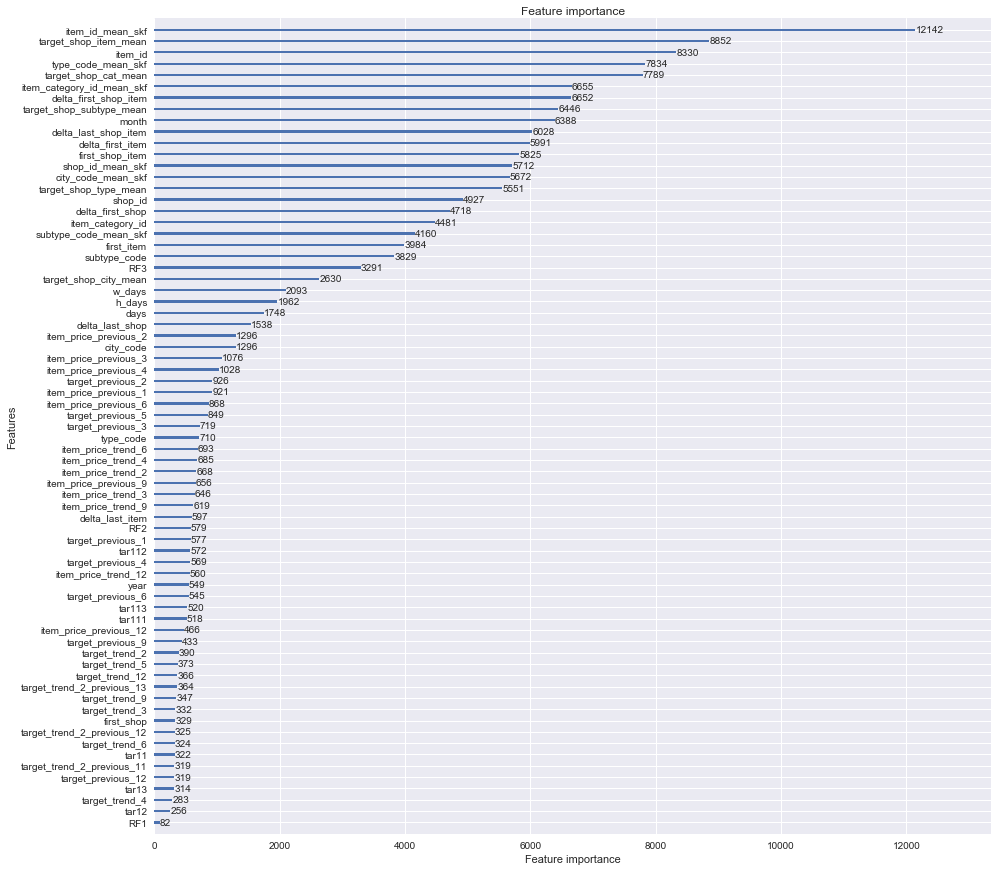

In [75]:
lgb_params3 = {'feature_fraction': 0.7,'metric': 'rmse', 'nthread':12, 
               'min_data_in_leaf': 2**11, 'lambda_l1': 1,
                'bagging_fraction': 0.7, 'learning_rate': 0.05, 'objective': 'rmse',
                'bagging_seed': 2**7, 'num_leaves': 2**11, 'bagging_freq':1, 'verbose':0}
model = lgb.train(lgb_params3, lgb.Dataset(XS, label=y['target']), 300)
ax = lgb.plot_importance(model, figsize=(15, 15));plt.show()

In [88]:
q=sorted(zip(model.feature_importance(), model.feature_name()))

In [119]:
cols1= [x[1] for x in q[-10:]]
cols2= [x[1] for x in q[-20:-5]]
cols3= [x[1] for x in q[:-10]]

# Training

In [135]:
def input_features_models(X_train, y_train, X_valid):

    tlevel1= []; vlevel1= []
    
    
    
    lgb_params1 = {'feature_fraction': 0.7,'metric': 'rmse', 'nthread':12, 'min_data_in_leaf': 2**3, 
                      'bagging_fraction': 0.7, 'learning_rate': 0.05, 'objective': 'rmse',
                      'bagging_seed': 2**7, 'num_leaves': 2**11,'bagging_freq':1,'verbose':0}

    lgb_params2 = {'feature_fraction': 0.7,'metric': 'rmse', 'nthread':12, 'min_data_in_leaf': 2**7, 
                  'bagging_fraction': 0.7, 'learning_rate': 0.05, 'objective': 'rmse',
                  'bagging_seed': 2**7, 'num_leaves': 2**11,'bagging_freq':1,'verbose':0}

    lgb_params3 = {'feature_fraction': 0.7,'metric': 'rmse', 'nthread':12, 'min_data_in_leaf': 2**11, 
                  'bagging_fraction': 0.7, 'learning_rate': 0.05, 'objective': 'rmse',
                  'bagging_seed': 2**7, 'num_leaves': 2**11,'bagging_freq':1,'verbose':0}

    for n, lgb_params in enumerate ([lgb_params1, lgb_params2, lgb_params3]):
        print('LGB')
        model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 30)
        #ax = lgb.plot_importance(model, figsize=(15, 15));plt.show()
        t_p= model.predict(X_train)
        tlevel1.append(t_p)
        v_p= model.predict(X_valid)
        vlevel1.append(v_p)
        
    
    for n, depth in enumerate ([2, 3, 4]):
        print('CAT')
        model = CatBoostRegressor(iterations=30, learning_rate=0.1, depth=depth)
        model.fit(X_train, y_train)
        t_p= model.predict(X_train)
        tlevel1.append(t_p)
        v_p= model.predict(X_valid)
        vlevel1.append(v_p)
    
    
    for n, depth in enumerate ([2, 3, 4]):
        print('RF')
        model= RandomForestRegressor(max_depth= depth, min_samples_split= 2**7, min_samples_leaf= 50, random_state= 0, n_estimators= 10)
        model.fit(X_train, y_train)
        t_p= model.predict(X_train)
        tlevel1.append(t_p)
        v_p= model.predict(X_valid)
        vlevel1.append(v_p)
    
    print('LR')    
    LRmodel= LinearRegression()
    Lmodel= Lasso()
    Rmodel= Ridge()
    BRmodel= BayesianRidge()
    for n, model in enumerate ([LRmodel, Lmodel, Rmodel, BRmodel]):
        model.fit(X_train, y_train)
        t_p= model.predict(X_train)
        tlevel1.append(t_p.squeeze())
        v_p= model.predict(X_valid)
        vlevel1.append(v_p.squeeze())
    
    return vlevel1, tlevel1

In [121]:
def predicted_features_models(X_train, y_train, X_valid):

    tlevel2= []; vlevel2= []
    
    print('BR')
    model= BayesianRidge()
    model.fit(X_train, y_train)
    t_p= model.predict(X_train)
    tlevel2.append(t_p)
    v_p= model.predict(X_valid)
    vlevel2.append(v_p)

    print('SVR')
    model= SVR(kernel= 'liniar', gamma='scale', C=1.0, epsilon=0.2, max_iter= 1000)
    model.fit(X_train, y_train)
    t_p= model.predict(X_train)
    tlevel2.append(t_p)
    v_p= model.predict(X_valid)
    vlevel2.append(v_p)

    print('KNN')
    KNNmodel= KNeighborsRegressor(n_neighbors=3, n_jobs=12)
    model.fit(X_train, y_train)
    t_p= model.predict(X_train)
    tlevel2.append(t_p)
    v_p= model.predict(X_valid)
    vlevel2.append(v_p)
    
    print('LGB')
    lgb_params = {'feature_fraction': 0.7,'metric': 'rmse', 'nthread':12, 'min_data_in_leaf': 2**11, 
                  'bagging_fraction': 0.7, 'learning_rate': 0.05, 'objective': 'rmse',
                  'bagging_seed': 2**7, 'num_leaves': 2**11,'bagging_freq':1,'verbose':0}
    
    model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 300)
    t_p= model.predict(X_train)
    tlevel2.append(t_p)
    v_p= model.predict(X_valid)
    vlevel2.append(v_p)

    return vlevel2, tlevel2

In [122]:
def rolling_prediction(k, last_bulk, XX, yy, df_test, n):
    predicted_train= pd.DataFrame() 
    for m in range(k, last_bulk + 1):
                print(m)
                chunk= np.arange(XX['date_bulk'].min(), m + 1)
                X_train= XX[XX['date_bulk'].isin(chunk)]
                y_train= yy[yy['date_bulk'].isin(chunk)]

                if m < last_bulk:
                    X_valid= XX[XX['date_bulk']== m + 1]

                    if n== 0:
                        vlevel1, _= input_features_models(X_train.drop('date_bulk', axis=1), y_train.drop('date_bulk', axis=1), X_valid.drop('date_bulk', axis=1))
                        df= pd.DataFrame(data= np.array(vlevel1).T, columns= np.arange(1, len(vlevel1) + 1))
                    else:
                        vlevel2, _= predicted_features_models(X_train.drop('date_bulk', axis=1), y_train.drop('date_bulk', axis=1), X_valid.drop('date_bulk', axis=1))
                        df= pd.DataFrame(data= np.array(vlevel2).T, columns= np.arange(1, len(vlevel2) + 1))


                    df['date_bulk']= m + 1

                    predicted_train= pd.concat([predicted_train, df], axis=0)
                else:
                    X_valid= df_test

                    vlevel2, tlevel2= level2_models(X_train.drop('date_bulk', axis=1), y_train.drop('date_bulk', axis=1), X_valid)
                    vlevel2= np.array(vlevel2).T
                    tlevel2= np.array(tlevel2).T
                    predicted_test= pd.DataFrame(data= vlevel2, columns= np.arange(1, vlevel2.shape[1] + 1))
    return predicted_train, predicted_test#, tlevel2, vlevel2

In [130]:
XS['date_bulk']= dbn.values.squeeze()
yy= y.copy()
yy.columns= ['target', 'date_bulk']
#yy['date_bulk']= dbn.values.squeeze()
last_bulk= XS['date_bulk'].max()
XS.columns

Index(['item_id', 'shop_id', 'city_code', 'item_category_id', 'type_code',
       'subtype_code', 'month', 'year', 'first_shop_item',
       'delta_first_shop_item', 'last_shop_item', 'delta_last_shop_item',
       'first_shop', 'delta_first_shop', 'last_shop', 'delta_last_shop',
       'first_item', 'delta_first_item', 'last_item', 'delta_last_item',
       'item_price_previous_1', 'item_price_previous_2',
       'item_price_previous_3', 'item_price_previous_4',
       'item_price_previous_6', 'item_price_previous_9',
       'item_price_previous_12', 'item_price_trend_2', 'item_price_trend_3',
       'item_price_trend_4', 'item_price_trend_6', 'item_price_trend_9',
       'item_price_trend_12', 'days', 'w_days', 'h_days', 'shop_id_mean_skf',
       'item_id_mean_skf', 'item_category_id_mean_skf', 'type_code_mean_skf',
       'subtype_code_mean_skf', 'city_code_mean_skf', 'target_shop_item_mean',
       'target_shop_city_mean', 'target_shop_cat_mean',
       'target_shop_type_mean', 't

## Inputs Level

In [ ]:
k= 30
predicted_train= []
predicted_test= []
for cols in [cols1, cols2, cols3, XS.columns]:
    predict_train, predict_test= rolling_prediction(k, last_bulk, XS[cols + ['date_bulk']], yy, test_dataS[cols], n=0)
    predicted_train.append(predict_train) 
    predicted_test.append(predict_test)
    
predicted_train= np.hstack(predicted_train)
predicted_test= np.hstack(predicted_test)

## Mid-Levels

In [ ]:
k= last_bulk-1

predicted_train, predicted_test= rolling_prediction(k, last_bulk, predicted_train, yy, predicted_test, n=1)

## Final level

In [ ]:
k= last_bulk

predicted_train, predicted_test= rolling_prediction(k, last_bulk, predicted_train, yy, predicted_test, n=2)

In [ ]:
BRmodel1= BayesianRidge()
BRmodel1.fit(tlevel2, y_train.drop('date_bulk', axis=1))
pr1= BRmodel1.predict(tlevel2).clip(0,20)
pr2= BRmodel1.predict(vlevel2).clip(0,20)
            
print('dbn 34 before final level (mean) rmse: ', np.sqrt(mean_squared_error(y['target'][yy['date_bulk']==34], df.drop('date_bulk', axis=1).mean(axis=1).clip(0,20))));
print('dbn 34 before final level rmse: ', np.sqrt(mean_squared_error(y['target'][yy['date_bulk']==34], df[4].clip(0,20))));

print('all modeling data rmse: ', np.sqrt(mean_squared_error(y['target'].iloc[-len(pr1):], pr1)));
print('dbn 34 rmse: ', np.sqrt(mean_squared_error(y['target'][yy['date_bulk']==34], pr1[-len(y['target'][yy['date_bulk']==34]):])));

# Pridiction

In [173]:
test_data['ID']= ID.values
ID= test_data[['ID']];
ID['ID']= ID['ID'].astype(int) 

#ID['item_cnt_month']= predicted_test.mean(axis=1).values;
#ID['item_cnt_month']= predicted_test[2].values; #!!!!!
ID['item_cnt_month']= pr2
ID['item_cnt_month']= ID['item_cnt_month'].clip(0,20)
ID.head(10)

c:\users\eitanp\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\eitanp\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
c:\users\eitanp\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

,ID,item_cnt_month
2781025,0,0.909075
2781026,1,0.598054
2781027,2,1.790960
2781028,3,0.446586
2781029,4,6.004537
2781030,5,0.851972
2781031,6,1.261256
2781032,7,0.226491
2781033,8,1.015073
2781034,9,0.585622


In [174]:
ID.to_csv('SUBMISSION03MAY_1.csv', index=False)